## 腾讯算法大赛 -- 模型设计

### 1. 特征：广告出价    模型：LightGBM

### 调参核心

调参1：提高准确率"：num_leaves, max_depth, learning_rate<br>
调参2：降低过拟合 max_bin min_data_in_leaf<br>
调参3：降低过拟合 正则化L1, L2<br>
调参4：降低过拟合 数据抽样 列抽样<br>

In [1]:
#import 
import gc
import time
import sys
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.cross_validation import StratifiedKFold

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:47: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from th

In [11]:
gc.collect()

413

In [14]:
# 自动获取model和result的保存path
def getModelPath(model):
    date = time.strftime('%m-%d %H:%M',time.localtime(time.time()+3600*8))
    model_path = "model/" + model + " " + date + ".model"
    return model_path

def getResultPath():
    date = time.strftime('%m-%d %H:%M',time.localtime(time.time()+3600*8))
    model_path = "result/" + date + ".result"
    return model_path

In [ ]:
# 多线程实现多参数学习

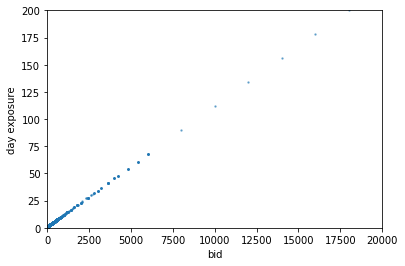

In [55]:
# plot: 特征和结果的分布

# read
result_df = pd.read_csv('submission.csv',sep=',',names=['id', 'quantity', 'bid'])
bid = result_df[['bid']].values
# label
quantity = result_df[['quantity']].values
plt.xlabel('bid')
plt.ylabel('day exposure')
plt.axis([0, 20000, 0, 200])
plt.scatter(y=quantity, x=bid,s=2, alpha =0.5)
plt.show()

In [ ]:
# eval function: sample, score, totalScore(for predicting test dataset, not train data)
def getSample(predict, label):
    return sum(2 * abs(predict - label)/(predict + label)) / predict.size


In [32]:
def getMonoScore (test_df, preds):
    test_sample_df = test_df[['广告id', '曝光广告出价bid']]
    
    test_sample_df['预测曝光量'] = preds
    test_sample_df.sort_values(by=["广告id","曝光广告出价bid"],inplace=True)
    
    # 作为基准
    standard=test_sample_df.groupby(by='广告id').head(1)
    standard.rename(columns={'曝光广告出价bid':'基准出价','预测曝光量':'基准曝光量'},inplace=True)
    
    test_sample_df=pd.merge(test_sample_df,standard,how="left",left_on='广告id', right_on='广告id')
    test_sample_df['score']=test_sample_df.apply(
        lambda x: (
                  ((x['基准曝光量']-x['预测曝光量'])* (x['基准出价']-x['曝光广告出价bid']))/
                   abs((x['基准曝光量']-x['预测曝光量'])* (x['基准出价']-x['曝光广告出价bid']))
                  )
        ,axis=1
    )
    
    monoscore=test_sample_df.groupby(by='广告id')['score'].mean().mean()
#     print("经过相关性计算成绩为："+str(monoscore))
    return 60*(monoscore+1)/2

In [17]:
getMonoScore(test_df,preds)
# preds: array
# test_df dataframe

### 2. 特征：广告出价/尺寸    模型：LightGBM

In [ ]:
# val : test with validation set
# test: predict with original test set

def trainLGB(train_type='val'):
    # read data
    print('Loading data...')
    if train_type == 'val':
#         train_df = pd.read_hdf('train_tri_data.h5')
#         test_df = pd.read_hdf('test_val_data.h5')
#         Y_train = np.load("label_arr.npy")
        #### train dataset
        train_arr = np.load('train_tri_arr_main.npy')
        product_id_arr = np.load('train_tri_arr_productid.npy')
        acc_id_arr = np.load('train_tri_arr_accid.npy')
        X_train = np.append(train_arr, product_id_arr, axis=1)
        X_train = np.append(X_train, acc_id_arr, axis=1)
        # train label
        Y_train = np.load('train_tri_arr_label.npy')
        
        #### test dataset
        train_arr = np.load('train_val_arr_main.npy')
        product_id_arr = np.load('train_val_arr_productid.npy')
        acc_id_arr = np.load('train_val_arr_accid.npy')
        X_test = np.append(train_arr, product_id_arr, axis=1)
        X_test = np.append(X_test, acc_id_arr, axis=1)
        # test label
        Y_train = np.load('train_val_arr_label.npy')
    elif train_type == 'test':
#         train_df = pd.read_hdf('train_sparse_data3.h5')
#         test_df = pd.read_hdf('test_data3.h5')
        train_arr = np.load('train_arr_main.npy')
        product_id_arr = np.load('train_arr_productid.npy')
        acc_id_arr = np.load('train_arr_accid.npy')
        X_train = np.append(train_arr, product_id_arr, axis=1)
        X_train = np.append(X_train, acc_id_arr, axis=1)
        
        Y_train = np.load('train_arr_label.npy')
        # todo: add X_test

    
    # feature : 曝光广告素材尺寸, 曝光广告出价bid

#     # training dataset
#     X_train = train_df[['曝光广告出价bid', '曝光广告素材尺寸']].values
#     # training label
#     Y_train = train_df[['日曝光量']].values
#     Y_train = Y_train.reshape(Y_train.size).tolist()


#     # test dataset
#     X_test = test_df[['曝光广告出价bid', '曝光广告素材尺寸']].values
#     # test label
#     if train_type == 'val':
#         Y_test = test_df['日曝光量'].values

    # result dataframe prepare
    # result_df = test_df['样本id']
    result_df = test_df.index

    # split train dataset into train data and validation data(0.1)
    # train_X, valid_X, train_Y, valid_Y = train_test_split(X_train, Y_train, test_size=0.1, random_state=2)

    # lgb_train = lgb.Dataset(train_X, label=train_Y)
    # lgb_val = lgb.Dataset(valid_X, label=valid_Y, reference=lgb_train)

    # eval result 
    evals_result = {}

    # create regressor
    model = lgb.LGBMRegressor(max_depth=5, #[1, 3, 5, 7, 9]
                              learning_rate=0.1, #[0.1, 0.05, 0.01, 0.001]
                              num_leaves=29, 
                              n_estimators=10000, #[100,200,500,1000,1500] => [1000,1200,1500,2000,2500]
                              subsample=0.8, #[0.6, 0.7, 0.8, 0.9]
                              colsample_bytree=1, #[0.6, 0.7, 0.8, 0.9]
                              subsample_for_bin=50000, 
                              min_child_weight=1, #[1, 3, 5]
                              reg_alpha=0, #[1e-05, 0.01, 0.1, 1, 100]
                              reg_lambda=1, #[1,5,10,50]
                              min_split_gain=0,
                              max_bin=425, 
                              seed=1000, 
                              objective='regression', 
                              min_child_samples=10,  subsample_freq=1,
                              nthread=4, silent=True, boosting_type='gbdt')



    ######### start cv training #############
    print("Start CV Training...")
    # cross validation 
    skf = list(StratifiedKFold(Y_train, n_folds=10, shuffle=True, random_state=1024))
    for i, (train, test) in enumerate(skf):
        print("Fold: ", i)
        start = time.time()
        # train model 
        model.fit(X_train[train], Y_train[train], eval_metric='l1',
                  eval_set=[(X_train[train], Y_train[train]), (X_train[test], Y_train[test])],
                  early_stopping_rounds=500)
        evals_result['prob_%s' % str(i)] = model.evals_result_
        # predict 
        preds = model.predict(X_test)
        end = time.time()
        # output the cost time
        print("The fold cost %f mins" % ((int(end) - int(start)) / 60))
        # save predict result into result_df
        result_df['prob_%s' % str(i)] = preds

        # eval model with specific metric
        if train_type == 'val':
            print("Sample: %f" % getSample(preds, Y_train))
#             print("Score: %f" % getScore(preds, Y_train))
        
    print("End CV Training...")
    ######### end cv training #############
    print("Saving Model " + getModelPath('lightGBM-val'))
    model.save_model(getModelPath('lightGBM-val'))
    
    
    
    ######### start training whole dataset #############
    if train_type == 'test':
        start = time.time()
        # train model 
        model.fit(X_train, Y_train, eval_metric='l1',
                  eval_set=[(X_train, Y_train), (X_train, Y_train)],
                  early_stopping_rounds=500)
        evals_result['final'] = model.evals_result_
        # predict 
        print("Predicting...")
        preds = model.predict(X_test)
        end = time.time()
        # output the cost time
        print("The fold cost %f mins" % ((int(end) - int(start)) / 60))
        # save predict result into result_df
        result_df['final'] = preds
        # save model
        print("Saving Model " + getModelPath('lightGBM-test'))
        model.save_model(getModelPath('lightGBM-test'))
        ######### end training whole dataset #############


        def checkPos(x):
            if x<0:
                return 0
            else:
                return x
        preds = [checkPos(x) for x in preds]

#         print(preds)

        ############### export preds as csv ###################
        out_predict_result =np.around(preds, decimals=4)

        predict = pd.DataFrame(out_predict_result).reset_index()
        predict['index'] = predict['index'].apply(lambda x: x+1)

        predict.to_csv(getResultPath(), header=0, index=0)
        predict.to_csv('submission.csv', header=0, index=0)


In [ ]:
######## export result as submission.csv

out_predict_result =np.around(predict_result, decimals=4)

predict = pd.DataFrame(out_predict_result).reset_index()
predict['index'] = predict['index'].apply(lambda x: x+1)

predict.to_csv(getResultPath(), header=0, index=0)
predict.to_csv('submission.csv', header=0, index=0)

In [ ]:
#######  plot metric 
print('训练结果图像...')
ax = lgb.plot_metric(evals_result, metric='l1') #metric的值与之前的params里面的值对应
plt.show()

print('特征重要性排序...')
ax = lgb.plot_importance(model, max_num_features=10)#max_features表示最多展示出前10个重要性特征，可以自行设置
plt.show()

### 3. 特征：尺寸    模型：LR 差

In [5]:
from sklearn import linear_model

# read data
train_df = pd.read_hdf('train_data1.h5')
test_df = pd.read_hdf('test_data1.h5')

# 加载你的数据
print('Load data...')
# feature : 曝光广告素材尺寸, 曝光广告出价bid
X_train = train_df[['曝光广告出价bid']].values
# label
Y_train = train_df[['日曝光量']].values
# Y_train = Y_train.reshape(Y_train.size).tolist()
# test data
X_test = test_df[['曝光广告出价bid']].values

# split train dataset into train data and validation data(0.1)
# train_X, valid_X, train_Y, valid_Y = train_test_split(X_train, Y_train, test_size=0.1, random_state=2)

# eval result 
evals_result = {}

######### start training #############
print("Start Training...")

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

print("End training...")

print(model._coef)

### 4. 特征：尺寸/bid 模型：xgboost

**调参的六个步骤：<br>**

默认参数后
1. 初始学习速率0.1和tree_based参数调优的估计器数目100 给其他参数一个初始值
2. max_depth 和 min_weight 它们对最终结果有很大的影响
3. gamma参数调优
4. 调整subsample 和 colsample_bytree 参数
5. 正则化参数调优
6. 进一步 降低学习速率 增加更多的树

In [ ]:
def trainXGB(train_type='val'):
    # read data
    print('Loading data...')
    if train_type == 'val':
#         train_df = pd.read_hdf('train_tri_data.h5')
#         test_df = pd.read_hdf('test_val_data.h5')
#         Y_train = np.load("label_arr.npy")
        #### train dataset
        train_arr = np.load('train_tri_arr_main.npy')
        product_id_arr = np.load('train_tri_arr_productid.npy')
        acc_id_arr = np.load('train_tri_arr_accid.npy')
        X_train = np.append(train_arr, product_id_arr, axis=1)
        X_train = np.append(X_train, acc_id_arr, axis=1)
        # train label
        Y_train = np.load('train_tri_arr_label.npy')
        
        #### test dataset
        train_arr = np.load('train_val_arr_main.npy')
        product_id_arr = np.load('train_val_arr_productid.npy')
        acc_id_arr = np.load('train_val_arr_accid.npy')
        X_test = np.append(train_arr, product_id_arr, axis=1)
        X_test = np.append(X_test, acc_id_arr, axis=1)
        # test label
        Y_train = np.load('train_val_arr_label.npy')
    elif train_type == 'test':
#         train_df = pd.read_hdf('train_sparse_data3.h5')
#         test_df = pd.read_hdf('test_data3.h5')
        train_arr = np.load('train_arr_main.npy')
        product_id_arr = np.load('train_arr_productid.npy')
        acc_id_arr = np.load('train_arr_accid.npy')
        X_train = np.append(train_arr, product_id_arr, axis=1)
        X_train = np.append(X_train, acc_id_arr, axis=1)
        
        Y_train = np.load('train_arr_label.npy')
        # todo: add X_test

    # feature : 曝光广告素材尺寸, 曝光广告出价bid

#     # training dataset
#     X_train = train_df[['曝光广告出价bid', '曝光广告素材尺寸']].values
#     # training label
#     Y_train = train_df[['日曝光量']].values
#     Y_train = Y_train.reshape(Y_train.size).tolist()


#     # test dataset
#     X_test = test_df[['曝光广告出价bid', '曝光广告素材尺寸']].values
#     # test label
#     if train_type == 'val':
#         Y_test = test_df['日曝光量'].values

    # result dataframe prepare
    # result_df = test_df['样本id']
    result_df = test_df.index

    # split train dataset into train data and validation data(0.1)
    # train_X, valid_X, train_Y, valid_Y = train_test_split(X_train, Y_train, test_size=0.1, random_state=2)

    # lgb_train = lgb.Dataset(train_X, label=train_Y)
    # lgb_val = lgb.Dataset(valid_X, label=valid_Y, reference=lgb_train)

    # eval result
    evals_result = {}

    # create regressor
    xgb.XGBRegressor(max_depth=5, #[3, 5, 7, 9]
                     learning_rate=0.1, #[0.1, 0.05, 0.01, 0.001]
                     n_estimators=100, #[100,200,500,1000,1500] => [1000,1200,1500,2000,2500]
                     min_child_weight=1, #[1, 3, 5]
                     gamma=0, #[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
                     subsample=0.8, #[0.6, 0.7, 0.8, 0.9]
                     colsample_bytree=1, #[0.6, 0.7, 0.8, 0.9]
                     reg_alpha=0, #[1e-05, 0.01, 0.1, 1, 100]
                     reg_lambda=1, #[1,5,10,50]
                     scale_pos_weight=1,
                     seed=1000,
                     n_jobs=4, # nthreads is deprecated
                     objective='reg:linear', booster='gbtree', verbosity=1, silent=True,
                     max_delta_step=0,   importance_type='gain', eval_metric='rmse',
                     colsample_bylevel=1, colsample_bynode=1,
                     base_score=0.5, random_state=0,  missing=None)


    ######### start cv training #############
    print("Start CV Training...")
    # cross validation
    skf = list(StratifiedKFold(Y_train, n_folds=10, shuffle=True, random_state=1024))
    for i, (train, test) in enumerate(skf):
        print("Fold: ", i)
        start = time.time()
        # train model
        model.fit(X_train[train], Y_train[train], eval_metric='l1',
                  eval_set=[(X_train[train], Y_train[train]), (X_train[test], Y_train[test])],
                  early_stopping_rounds=500)
        evals_result['prob_%s' % str(i)] = model.evals_result()
        # predict
        preds = model.predict(X_test)
        end = time.time()
        # output the cost time
        print("The fold cost %f mins" % ((int(end) - int(start)) / 60))
        # save predict result into result_df
        result_df['prob_%s' % str(i)] = preds

        # eval model with specific metric
        if train_type == 'val':
            print("Sample: %f" % getSample(preds, Y_train))
#             print("Score: %f" % getScore(preds, Y_train))

    print("End CV Training...")
    ######### end cv training #############
    # save model
    print("Saving Model " + getModelPath('Xgboost-val'))
    model.save_model(getModelPath('Xgboost-val'))
    

    ######### start training whole dataset #############
    if train_type == 'test':
        start = time.time()
        # train model
        model.fit(X_train, Y_train, eval_metric='l1',
                  eval_set=[(X_train, Y_train), (X_train, Y_train)],
                  early_stopping_rounds=500)
        evals_result['final'] = model.evals_result()
        # predict
        print("Predicting...")
        preds = model.predict(X_test)
        end = time.time()
        # output the cost time
        print("The fold cost %f mins" % ((int(end) - int(start)) / 60))
        # save predict result into result_df
        result_df['final'] = preds

        # save model
        print("Saving Model " + getModelPath('Xgboost-test'))
        model.save_model(getModelPath('Xgboost-test'))
        ######### end training whole dataset #############


        def checkPos(x):
            if x<0:
                return 0
            else:
                return x
        preds = [checkPos(x) for x in preds]

#         print(preds)

        ############### export preds as csv ###################
        out_predict_result =np.around(preds, decimals=4)

        predict = pd.DataFrame(out_predict_result).reset_index()
        predict['index'] = predict['index'].apply(lambda x: x+1)

        predict.to_csv(getResultPath(), header=0, index=0)
        predict.to_csv('submission.csv', header=0, index=0)


### 5. 特征：bid 模型：线性模型（根据出价的单调性实现）


* 这里我们通过调参的方式使得SMAPLE值更加的小，从而使得最终分数更加的多

参数：
k/b

In [50]:
# read data
train_df = pd.read_hdf('train_data1.h5')
test_df = pd.read_hdf('test_data1.h5')

# train_df['曝光广告出价bid']= np.around(train_df['曝光广告出价bid'], decimals=2)
predict_result = test_df['曝光广告出价bid'].apply(lambda x: 0.0111*x + 0.99)

out_predict_result =np.around(predict_result, decimals=4)

predict = pd.DataFrame(out_predict_result).reset_index()
predict['index'] = predict['index'].apply(lambda x: x+1)
predict['bid']= test_df['曝光广告出价bid']
predict.rename(columns={'曝光广告出价bid':'day_exposure'}, inplace=True)

predict.to_csv(getResultPath(), header=0, index=0)
predict.to_csv('submission.csv', header=0, index=0)


* 学习线性参数

k - 0.01-0.1 0.01<br>
b - 1~100 1<br>
finall find:
**optimal: k=0.01~0.02 / b=4~8**

In [ ]:
################# 小数点后两位 ############
param_list = []
sample_list = []
# print(predict_result)
train_label = train_df['日曝光量'].values

# 10*100= 1000种
for i in range(1, 10 , 1):
    for j in range(1, 100, 1):
        param_list += [[0.01*i, j]]
        predict = train_df['曝光广告出价bid'].apply(lambda x: 0.01*i*x+j).values
        sample = sum(2 * abs(predict - train_label)/(predict + train_label)) / train_label.size
        sample_list += [sample]
        print(sample)

k - 0.01~0.02 0.001<br>
b - 1~10 0.1 <br>
**optimal: k=0.011~0.012 / b=5.4~5.7**

In [ ]:
############## 小数点后三位 ##############
param_list1 = []
sample_list1 = []
# print(predict_result)
train_label = train_df['日曝光量'].values

# 10*100= 1000种
for i in range(1, 10 , 1):
    for j in range(1, 100, 1):
        param_list1 += [[0.01+0.001*i, 0.1*j]]
        predict = train_df['曝光广告出价bid'].apply(lambda x: (0.01+0.001*i)*x+0.1*j).values
        sample = sum(2 * abs(predict - train_label)/(predict + train_label)) / train_label.size
        sample_list1 += [sample]
        print(sample)


In [ ]:
########## 筛选参数 #################
sample_arr1 = np.array(sample_list1)
param_arr1= np.array(param_list1)
# param_arr1[np.argwhere(sample_arr1 < 1.0112)]

k - 0.011~0.012 0.0001<br>
b - 5.4~5.7 0.01 <br>
**optimal: k=0.0111 / b=5.55**

In [ ]:
param_list2 = []
sample_list2 = []
# print(predict_result)
train_label = train_df['日曝光量'].values

# 10*100= 1000种
for i in range(1, 10, 1):
    for j in range(1, 30, 1):
        param_list2 += [[0.011+0.0001*i, 0.01*j]]
        predict = train_df['曝光广告出价bid'].apply(lambda x: (0.011+0.0001*i)*x+0.01*j).values
        sample = sum(2 * abs(predict - train_label)/(predict + train_label)) / train_label.size
        sample_list2 += [sample]
        print(sample)


### 6. RandomForest model